Préparation des Données, Augmentation et Entraînement du Modèle

In [ ]:
#Importation des bibliothèques nécessaires
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB2
import matplotlib.pyplot as plt

#Liste des classes cibles pour la classification
target_classes = ['steak', 'tacos', 'pizza', 'donuts', 'tiramisu']

#Définition des chemins des données et des métadonnées
data_dir = r"C:\Users\lenovo\Downloads\food-102\images"
meta_dir = r"C:\Users\lenovo\Downloads\food-102\meta"
#Chemin vers le fichier d'entraînement
train_file = os.path.join(meta_dir, "train.txt")
#Chemin vers le fichier de test
test_file = os.path.join(meta_dir, "test.txt")

#Fonction pour charger les chemins des images et leurs étiquettes
def load_data(file_path):
    images, labels = [], []
    #Lecture du fichier contenant les informations des images
    with open(file_path, "r") as f:
        for line in f:
            #Séparation de l'étiquette et du nom de l'image
            label, image_name = line.strip().split("/")
            #Filtrage des classes cibles
            if label in target_classes:
                #Construction du chemin complet de l'image
                image_path = os.path.join(data_dir, label, f"{image_name}.jpg")
                #Vérification de l'existence de l'image
                if os.path.exists(image_path):
                    #Ajout du chemin de l'image
                    images.append(image_path)
                    #Ajout de l'index de l'étiquette
                    labels.append(target_classes.index(label))
    #Retourne les chemins et les étiquettes
    return images, labels

#Chargement des données d'entraînement et de test
train_paths, train_labels = load_data(train_file)
test_paths, test_labels = load_data(test_file)

#Dimensions des images et nombre de classes
image_size = (224, 224)
num_classes = len(target_classes)

#Prétraitement des images (redimensionnement et normalisation)
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  #Décodage de l'image
    image = tf.image.resize(image, image_size)  #Redimensionnement
    image = image / 255.0  #Normalisation des pixels
    #Retourne l'image prétraitée et l'étiquette
    return image, label

#Augmentation des données pour améliorer la robustesse du modèle
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  #Retournement horizontal aléatoire
    layers.RandomRotation(0.2),  #Rotation aléatoire jusqu'à 20%
    layers.RandomZoom(0.2)  #Zoom aléatoire jusqu'à 20%
])

#Prétraitement avec augmentation pour l'entraînement
def preprocess_image_with_augmentation(image_path, label):
    image, label = preprocess_image(image_path, label)
    #Application de l'augmentation
    image = data_augmentation(image)
    #Retourne l'image augmentée et l'étiquette
    return image, label

#Création des datasets TensorFlow pour l'entraînement et le test
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))

#Prétraitement et configuration des datasets (batching, préchargement)
train_dataset = train_dataset.map(preprocess_image_with_augmentation).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)

#Chargement de EfficientNetB2 comme modèle de base
base_model = EfficientNetB2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
#Activation du fine-tuning du modèle
base_model.trainable = True

#Construction du modèle final
model = models.Sequential([
    base_model,  #Extraction de caractéristiques avec EfficientNetB2
    layers.GlobalAveragePooling2D(),  #Poolling global pour réduire la dimension
    layers.Dropout(0.3),  #Dropout pour éviter le sur-apprentissage
    layers.Dense(num_classes, activation="softmax")  #Couche de sortie pour la classification
])

#Compilation du modèle avec l'optimiseur Adam et une faible valeur de learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  #Optimiseur Adam
    loss="sparse_categorical_crossentropy",  #Perte pour classification multi-classes
    metrics=["accuracy"]  #Mesure de l'exactitude
)

#Entraînement du modèle avec validation
history = model.fit(
    train_dataset,  #Jeu de données d'entraînement
    validation_data=test_dataset,  #Jeu de données de test/validation
    epochs=30  #Nombre d'époques
)

Epoch 1/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 1039s 8s/step - accuracy: 0.2569 - loss: 1.6131 - val_accuracy: 0.1928 - val_loss: 1.6310
Epoch 2/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 971s 8s/step - accuracy: 0.3730 - loss: 1.4806 - val_accuracy: 0.1976 - val_loss: 1.6955
Epoch 3/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 930s 8s/step - accuracy: 0.4665 - loss: 1.3678 - val_accuracy: 0.2520 - val_loss: 1.5665
Epoch 4/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 906s 8s/step - accuracy: 0.4943 - loss: 1.2863 - val_accuracy: 0.5360 - val_loss: 1.2581
Epoch 5/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 922s 8s/step - accuracy: 0.5448 - loss: 1.1940 - val_accuracy: 0.5928 - val_loss: 1.1736
Epoch 6/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 920s 8s/step - accuracy: 0.5733 - loss: 1.1342 - val_accuracy: 0.5936 - val_loss: 1.1202
Epoch 7/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 968s 8s/step - accuracy: 0.6097 - loss: 1.0470 - val_accuracy: 0.7776 - val_loss: 0.7986
Epoch 8/30
118/118 ━━━━━━━━━━━━━━━━━━━━ 986s 8s/step - accuracy: 0.6019 - loss: 1.0137 - val_acc

Évaluation du Modèle et Sauvegarde Finale

Accuracy finale sur l'ensemble d'entraînement : 0.8531
Accuracy finale sur l'ensemble de validation : 0.9408


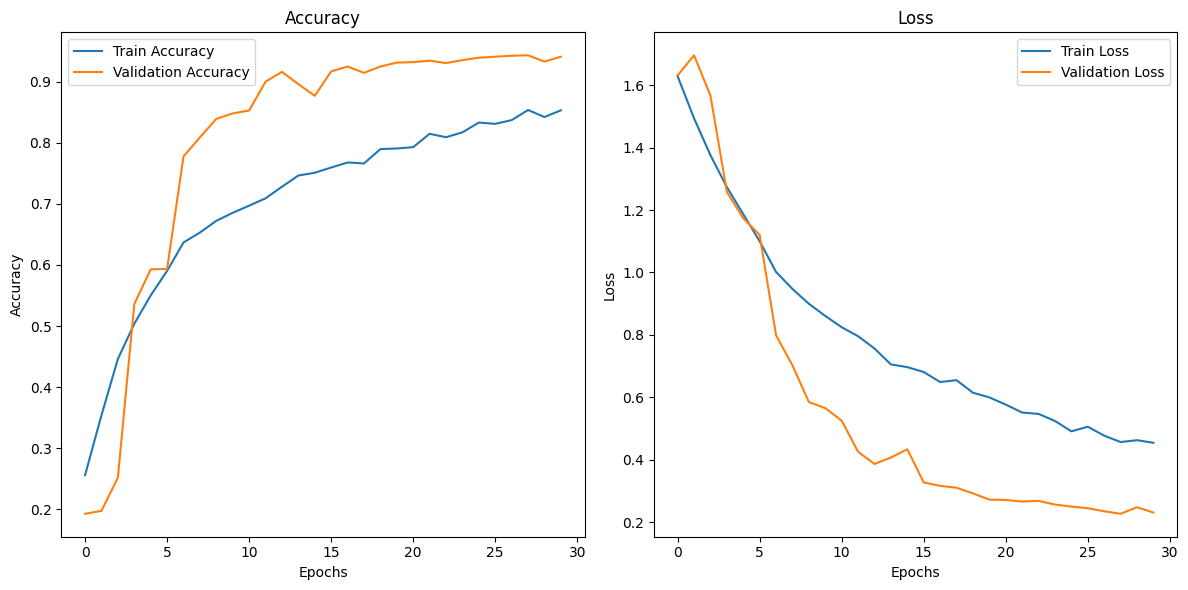

Modèle complet sauvegardé


In [ ]:
#Récupération de l'exactitude de l'entraînement et de la validation
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
#Récupération de la perte de l'entraînement et de la validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Récupération de l'exactitude finale sur l'ensemble d'entraînement
final_train_accuracy = history.history['accuracy'][-1]
#Récupération de l'exactitude finale sur l'ensemble de validation
final_val_accuracy = history.history['val_accuracy'][-1]

#Affichage de l'exactitude finale sur l'entraînement et la validation
print(f"Accuracy finale sur l'ensemble d'entraînement : {final_train_accuracy:.4f}")
print(f"Accuracy finale sur l'ensemble de validation : {final_val_accuracy:.4f}")

#Création d'une figure pour afficher les courbes
plt.figure(figsize=(12, 6))

#Sous-graphique pour afficher l'exactitude
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')  #Tracé de l'exactitude d'entraînement
plt.plot(val_accuracy, label='Validation Accuracy')  #Tracé de l'exactitude de validation
plt.title('Accuracy')  #Titre du graphique
plt.xlabel('Epochs')  #Label de l'axe des abscisses
plt.ylabel('Accuracy')  #Label de l'axe des ordonnées
plt.legend()  #Affichage de la légende

#Sous-graphique pour afficher la perte
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')  #Tracé de la perte d'entraînement
plt.plot(val_loss, label='Validation Loss')  #Tracé de la perte de validation
plt.title('Loss')  #Titre du graphique
plt.xlabel('Epochs')  #Label de l'axe des abscisses
plt.ylabel('Loss')  #Label de l'axe des ordonnées
plt.legend()  #Affichage de la légende

#Optimisation de la mise en page
plt.tight_layout()
#Affichage des graphiques
plt.show()

#Définition du chemin pour sauvegarder le modèle
model_save_path = r"C:\Users\lenovo\Downloads\food_model_complete__59.keras"
#Sauvegarde du modèle complet
model.save(model_save_path)
#Affichage du message de confirmation
print(f"Modèle complet sauvegardé")

Prédiction d'une Image Test

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Classe prédite : pizza avec une probabilité de 0.81


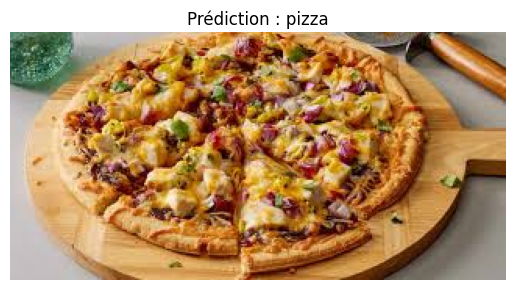

In [ ]:
#Importation des utilitaires nécessaires pour charger et prétraiter l'image
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

#Fonction pour charger et prétraiter une image (redimensionnement, normalisation)
def load_and_preprocess_image(image_path):
    #Chargement de l'image avec redimensionnement à 224x224
    image = load_img(image_path, target_size=(224, 224))
    #Conversion de l'image en tableau numpy
    image_array = img_to_array(image)
    #Normalisation des pixels (valeurs entre 0 et 1)
    image_array = image_array / 255.0
    #Ajout d'une dimension supplémentaire pour correspondre à la forme d'entrée du modèle
    image_array = np.expand_dims(image_array, axis=0)
    #Retourne l'image prétraitée
    return image_array

#Chemin de l'image de test
test_image_path = r"C:\Users\lenovo\Downloads\pizza2.jpg"

#Chargement et prétraitement de l'image de test
test_image = load_and_preprocess_image(test_image_path)

#Prédiction des classes par le modèle
predictions = model.predict(test_image)

#Récupération de l'index de la classe prédite
predicted_class_index = np.argmax(predictions, axis=1)[0]
#Récupération du nom de la classe prédite
predicted_class = target_classes[predicted_class_index]

#Affichage de la classe prédite et de la probabilité
print(f"Classe prédite : {predicted_class} avec une probabilité de {predictions[0][predicted_class_index]:.2f}")

#Affichage de l'image de test avec le titre de la prédiction
plt.imshow(load_img(test_image_path))
plt.title(f"Prédiction : {predicted_class}")
#Suppression des axes pour une meilleure visualisation
plt.axis("off")
#Affichage de l'image
plt.show()

Chargement du Modèle Sauvegardé et Prédiction sur une Image Test

Modèle chargé depuis : C:\Users\lenovo\Downloads\food_model_complete__59.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classe prédite : pizza avec une probabilité de 0.81


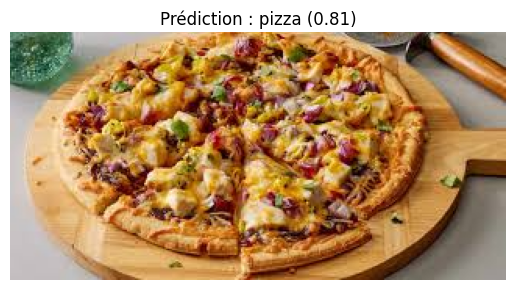

In [ ]:
#Importation des utilitaires nécessaires pour charger le modèle et l'image
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

#Fonction pour charger et prétraiter une image (redimensionnement, normalisation)
def load_and_preprocess_image(image_path):
    #Chargement de l'image avec redimensionnement à 224x224
    image = load_img(image_path, target_size=(224, 224))
    #Conversion de l'image en tableau numpy
    image_array = img_to_array(image)
    #Normalisation des pixels (valeurs entre 0 et 1)
    image_array = image_array / 255.0
    #Ajout d'une dimension supplémentaire pour correspondre à la forme d'entrée du modèle
    image_array = np.expand_dims(image_array, axis=0)
    #Retourne l'image prétraitée
    return image_array

#Chemin du modèle sauvegardé
model_save_path = r"C:\Users\lenovo\Downloads\food_model_complete__59.keras"
#Chargement du modèle sauvegardé
model = load_model(model_save_path)
#Affichage de la confirmation du modèle chargé
print(f"Modèle chargé depuis : {model_save_path}")

#Liste des classes cibles pour la prédiction
target_classes = ['steak', 'tacos', 'pizza', 'donuts', 'tiramisu']

#Chemin de l'image de test
test_image_path = r"C:\Users\lenovo\Downloads\pizza2.jpg"

#Chargement et prétraitement de l'image de test
test_image = load_and_preprocess_image(test_image_path)

#Prédiction des classes par le modèle
predictions = model.predict(test_image)
#Récupération de l'index de la classe prédite
predicted_class_index = np.argmax(predictions, axis=1)[0]
#Récupération du nom de la classe prédite
predicted_class = target_classes[predicted_class_index]

#Récupération de la probabilité associée à la classe prédite
probability = predictions[0][predicted_class_index]
#Affichage de la classe prédite et de la probabilité
print(f"Classe prédite : {predicted_class} avec une probabilité de {probability:.2f}")

#Affichage de l'image de test avec le titre de la prédiction
plt.imshow(load_img(test_image_path))
#Affichage du titre avec la classe et la probabilité
plt.title(f"Prédiction : {predicted_class} ({probability:.2f})")
#Suppression des axes pour une meilleure visualisation
plt.axis("off")
#Affichage de l'image
plt.show()

Conversion et Sauvegarde d'un Modèle Keras en TensorFlow Lite

In [8]:
#Importation de TensorFlow pour la conversion du modèle
import tensorflow as tf

#Définition du chemin pour sauvegarder le modèle Keras
model_save_path = r"C:\Users\lenovo\Downloads\food_model_complete__59.keras"
#Sauvegarde du modèle Keras au format .keras
model.save(model_save_path)
#Affichage du message de confirmation de sauvegarde du modèle
print(f"Modèle complet Keras sauvegardé à : {model_save_path}")

#Chargement du modèle Keras sauvegardé
model = tf.keras.models.load_model(model_save_path)

#Conversion du modèle Keras en modèle TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
#Conversion effective du modèle
tflite_model = converter.convert()

#Définition du chemin pour sauvegarder le modèle TensorFlow Lite
tflite_model_save_path = r"C:\Users\lenovo\Downloads\food_model_complete__59.tflite"
#Écriture du modèle TensorFlow Lite dans un fichier
with open(tflite_model_save_path, "wb") as f:
    f.write(tflite_model)
#Affichage du message de confirmation de sauvegarde du modèle TensorFlow Lite
print(f"Modèle TensorFlow Lite sauvegardé à : {tflite_model_save_path}")

Modèle complet Keras sauvegardé à : C:\Users\lenovo\Downloads\food_model_complete__59.keras
Saved artifact at '/tmp/tmp8zm4e1kg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137195722084896: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137195718316928: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137195722252432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137195722245392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137195722257712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137195722255424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137195722256480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137195722257008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137195722262128: TensorSpec(shape=(), dtype